# Partially coded field of view with 2D masks

In [33]:
import numpy as np
import numpy.typing as npt
from scipy.signal import correlate
import matplotlib.pyplot as plt

We modify the function to generate URA mask so that it may return wrap-padded masks. This is to avoid confusion when padding with zeros for PCFOV. 

In [34]:
from masks.utils import is_prime

def ura(r: int, s: int, m: int = 1, wrap_border=False) -> tuple[npt.NDArray, npt.NDArray]:
    """
    Generates a URA mask and its decoding array.

    From: `https://github.com/bpops/codedapertures` by https://github.com/bpops
    All credits reserved and thank you very much!
    TODO: bundle a license

    :param r: number of rows
    :param s: number of columns
    :param m: number of tiles
    :param wrap_borders: will wrap the fundamental tile around its border.
    :return: the mask array and its decoding array.
    """
    assert is_prime(r)
    assert is_prime(s)
    assert r - s == 2

    c_r_i = np.zeros(r) - 1
    c_s_j = np.zeros(s) - 1
    for x in range(1, r):
        c_r_i[x**2 % r] = 1
    for y in range(1, s):
        c_s_j[y**2 % s] = 1

    _a_ij = np.zeros([r, s])
    for i in range(r):
        for j in range(s):
            if i == 0:
                _a_ij[i, j] = 0
            elif j == 0:
                _a_ij[i, j] = 1
            elif c_r_i[i] * c_s_j[j] == 1:
                _a_ij[i, j] = 1

    a_ij = np.zeros([m * r, m * s])
    for i in range(m * r):
        for j in range(m * s):
            a_ij[i, j] = _a_ij[i % r, j % s]
    a_ij = np.roll(a_ij, int((r + 1) / 2), axis=0)
    a_ij = np.roll(a_ij, int((s + 1) / 2), axis=1)

    g_ij = a_ij.copy()
    g_ij[g_ij == 0] = -1

    if wrap_border:
        wrapped_aij, wrapped_gij = map(lambda m: np.pad(
                m,
                pad_width=[(int(dim / 2), int(dim / 2)) for dim in m.shape],
                mode="wrap",
            ), [a_ij, g_ij])
        return wrapped_aij, wrapped_gij
    return a_ij, g_ij

Now a function for zero-padding:

In [35]:
def zero_pad(a: npt.NDArray) -> npt.NDArray:
    n, m = a.shape
    return np.pad(a, pad_width=((n // 2, n // 2), (m // 2, m // 2)), mode="constant")

Let's build the mask and the decoder:

In [36]:
a, g = map(lambda x: zero_pad(x), ura(61, 59, wrap_border=True))

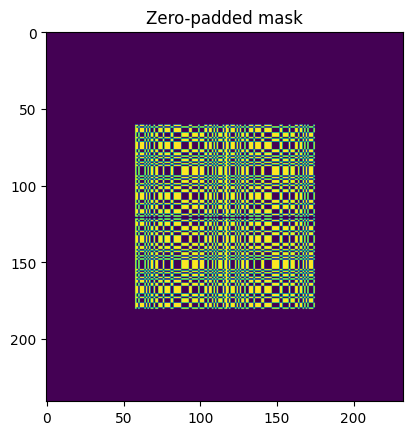

In [37]:
plt.imshow(a); plt.title("Zero-padded mask"); plt.show()

Now we generate a source

In [38]:
n, m = a.shape
source = np.zeros((n - n // 4, m - m // 4))
source[100, 100] = 100

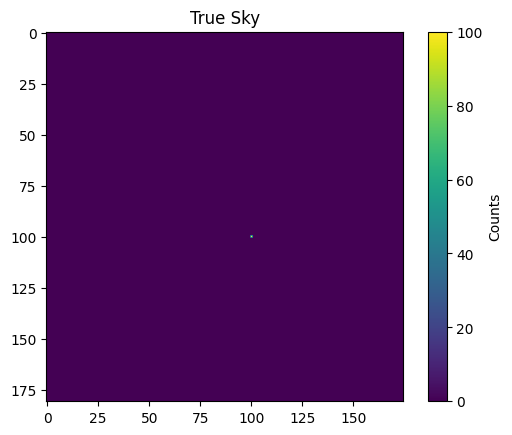

In [39]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(source)
fig.colorbar(c0, ax=ax, label="Counts")
ax.set_title("True Sky")
plt.show()

We encode the source into a detector image.

In [61]:
def encode(source: npt.NDArray, mask: npt.NDArray) -> npt.NDArray:
    n, m = source.shape
    detector = correlate(a, source)[n - 1 : -n + 1, m - 1 : -m + 1]
    return detector

detector = encode(source, a)

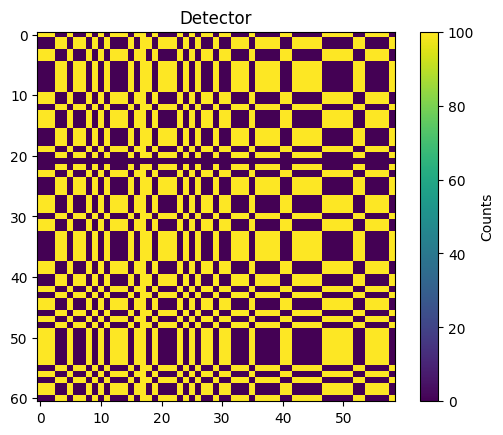

In [62]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(detector)
fig.colorbar(c0, ax=ax, label="Counts")
ax.set_title("Detector")
plt.show()

Note: this requires a normalization!

Let's decode it. We can see coding noise along the mask axis and ghosts in the PCFOV.

In [49]:
def cross_correlation(detector: npt.NDArray, decoder:npt.NDArray):
    n, m = detector.shape
    reconstructed = correlate(decoder, detector)[n - 1 : -n + 1, m - 1 : -m + 1]
    return reconstructed

source_ = cross_correlation(detector, g)

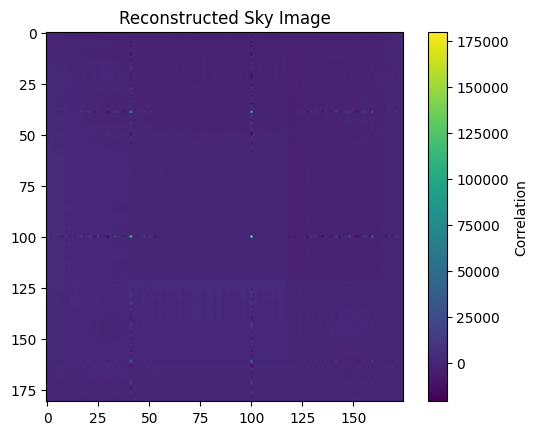

In [50]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(source_)
fig.colorbar(c0, ax=ax, label="Correlation")
ax.set_title("Reconstructed Sky Image")
plt.show()